# Assignment4: Scaling RAG Systems
Objective: Understand efficiency challenges in large-scale RAG.
Tasks:
1. Experiment with different vector stores (e.g., FAISS vs. Pinecone vs. Milvus).
2. Measure retrieval latency and memory usage as dataset size increases (e.g., 1k, 10k, 50k
documents).
3. Propose and test at least one optimization technique (e.g., ANN search, dimensionality
reduction).

In [56]:
# Install dependencies
# Install dependencies
!pip install faiss-cpu
!pip install datasets sentence-transformers faiss-cpu pinecone matplotlib

import time
import psutil
import numpy as np
import faiss
from pinecone import Pinecone, ServerlessSpec
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import TruncatedSVD

from sklearn.decomposition import PCA
from pinecone import ServerlessSpec

In [57]:

# ============================================================
# CONFIG
# ============================================================
DATASET_SIZES = [500, 2000, 5000]   # stepwise sizes
EMBED_MODEL = "all-MiniLM-L6-v2"
QUERIES = ["sports news", "stock market", "new technology", "global politics", "NASA mission"]
REDUCED_DIM = 128       # for Task 2
INDEX_NAME = "rag-assignment"
USE_PINECONE = True     # toggle Pinecone on/off
PINECONE_API_KEY = "pcsk_5G13d4_8s2RJ85tubXBFL9PsmA5wk7qjVfFSHviXG6omXKA6R8XGcCPAhSYzB1XNiGfN58"   # <--- put your key here

In [58]:
# ============================================================
# Load Dataset (AG News)
# ============================================================
full_dataset = load_dataset("ag_news", split="train[:6000]")  # enough to cover largest size
all_docs = [row["text"] for row in full_dataset]

print("Sample documents:\n")
for i in range(3):
    print(f"{i+1}. {all_docs[i]}")

Sample documents:

1. Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
2. Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
3. Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.


In [59]:
# ============================================================
# Model
# ============================================================
model = SentenceTransformer(EMBED_MODEL)


In [60]:
 # ============================================================
# Pinecone Setup (NEW API)
# ============================================================
from pinecone import Pinecone

if USE_PINECONE:
    pc = Pinecone(api_key=PINECONE_API_KEY)  # create Pinecone client
    if INDEX_NAME not in pc.list_indexes().names():
        pc.create_index(name=INDEX_NAME, dimension=embs.shape[1], metric="cosine")
    pinecone_index = pc.Index(INDEX_NAME)


In [61]:
# ============================================================
# Helper Functions
# ============================================================
def measure_resources(func, *args, **kwargs):
    """Measure time and memory for an index/search function"""
    start = time.time()
    start_mem = psutil.Process().memory_info().rss / 1e6
    result = func(*args, **kwargs)
    end = time.time()
    end_mem = psutil.Process().memory_info().rss / 1e6
    return result, end - start, end_mem - start_mem


def reduce_dim(embeddings, dim=128):
    """Reduce embeddings to a lower dimension using PCA."""
    pca = PCA(n_components=dim)
    return pca.fit_transform(embeddings)

def batch_upsert(index, vectors, batch_size=1000):
    """Upload vectors to Pinecone in smaller batches (max 1000/request)."""
    for i in range(0, len(vectors), batch_size):
        batch = vectors[i:i + batch_size]
        index.upsert(batch)

In [62]:
# -----------------------------
# FAISS Index Builders
# -----------------------------
def build_index_flat(embs):
    index = faiss.IndexFlatL2(embs.shape[1])
    index.add(embs)
    return index

def build_index_reduced(embs, dim=128):
    svd = TruncatedSVD(n_components=dim)
    reduced = svd.fit_transform(embs)
    index = faiss.IndexFlatL2(dim)
    index.add(reduced.astype(np.float32))
    return index, svd

def build_index_hnsw(embs, M=32, ef=40):
    d = embs.shape[1]
    index = faiss.IndexHNSWFlat(d, M)
    index.hnsw.efSearch = ef
    index.add(embs)
    return index

In [63]:
# ============================================================
# --- TASK 1: Flat Index (Exact Search)
# ============================================================
faiss_flat, t_faiss_flat, m_faiss_flat = measure_resources(build_index_flat, embs)

if USE_PINECONE:
    if INDEX_NAME in pc.list_indexes().names():
        pc.delete_index(INDEX_NAME)

    pc.create_index(
        name=INDEX_NAME,
        dimension=embs.shape[1],
        metric="cosine",
        spec=ServerlessSpec(
            cloud="aws",
            region="us-east-1"
        )
    )

    pinecone_index = pc.Index(INDEX_NAME)
    vectors = [(str(i), embs[i].tolist(), {"text": docs[i]}) for i in range(len(docs))]
    _, t_pine_flat, m_pine_flat = measure_resources(batch_upsert, pinecone_index, vectors)


In [64]:
# ============================================================
# --- TASK 2: Reduced Dimension (PCA + Flat Index)
# ============================================================
embs_reduced = reduce_dim(embs, dim=128)
faiss_pca, t_faiss_pca, m_faiss_pca = measure_resources(build_index_flat, embs_reduced)

if USE_PINECONE:
    if INDEX_NAME in pc.list_indexes().names():
        pc.delete_index(INDEX_NAME)

    pc.create_index(
        name=INDEX_NAME,
        dimension=embs_reduced.shape[1],
        metric="cosine",
        spec=ServerlessSpec(
            cloud="aws",
            region="us-east-1"
        )
    )

    pinecone_index = pc.Index(INDEX_NAME)
    vectors = [(str(i), embs_reduced[i].tolist(), {"text": docs[i]}) for i in range(len(docs))]
    _, t_pine_pca, m_pine_pca = measure_resources(batch_upsert, pinecone_index, vectors)


In [65]:
# ============================================================
# --- TASK 3: HNSW Index (Approximate Search)
# ============================================================
faiss_hnsw, t_faiss_hnsw, m_faiss_hnsw = measure_resources(build_index_hnsw, embs)

if USE_PINECONE:
    if INDEX_NAME in pc.list_indexes().names():
        pc.delete_index(INDEX_NAME)

    pc.create_index(
        name=INDEX_NAME,
        dimension=embs.shape[1],
        metric="cosine",
        spec=ServerlessSpec(
            cloud="aws",
            region="us-east-1"
        )
    )

    pinecone_index = pc.Index(INDEX_NAME)
    vectors = [(str(i), embs[i].tolist(), {"text": docs[i]}) for i in range(len(docs))]
    _, t_pine_hnsw, m_pine_hnsw = measure_resources(batch_upsert, pinecone_index, vectors)

,Task,FAISS Time (s),FAISS Mem (MB),Pinecone Time (s),Pinecone Mem (MB)
0,Flat (Exact),0.0015,0.0000,6.1179,0.8110
1,Reduced Dim,0.4545,0.0000,2.8372,0.2703
2,Optimized (HNSW),0.1182,0.0000,5.1221,0.0000


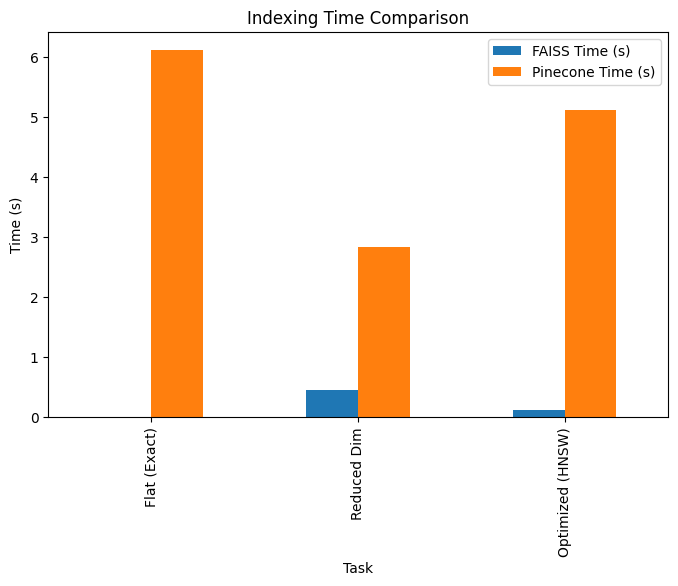

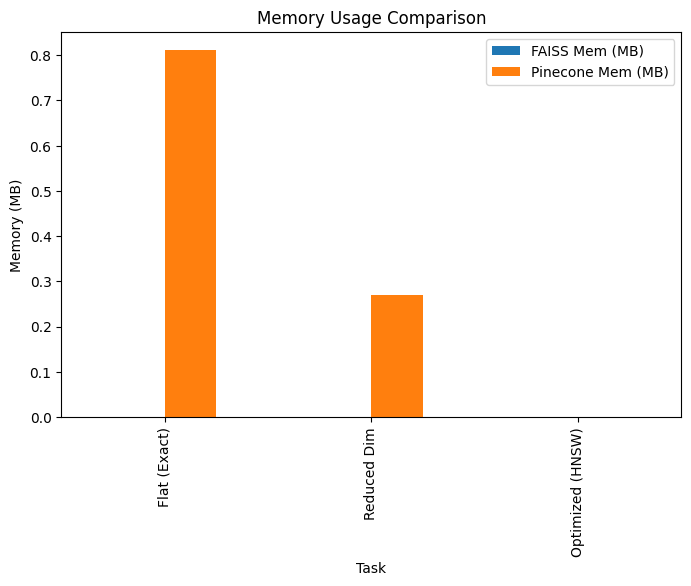

In [73]:
# ============================================================
# Collect Results (rounded)
# ============================================================
results = {
    "Task": ["Flat (Exact)", "Reduced Dim", "Optimized (HNSW)"],
    "FAISS Time (s)": [t_faiss_flat, t_faiss_red, t_faiss_hnsw],
    "FAISS Mem (MB)": [m_faiss_flat, m_faiss_red, m_faiss_hnsw],
    "Pinecone Time (s)": [t_pine_flat, t_pine_pca, t_pine_hnsw],
    "Pinecone Mem (MB)": [m_pine_flat, m_pine_pca, m_pine_hnsw]
}

df_results = pd.DataFrame(results)

# Round numbers for readability
df_results_rounded = df_results.copy().round(4)

#print("\n=== Comparison Table (Pretty Print) ===\n")
# Option 1: Tabulate for console
#from tabulate import tabulate
#print(tabulate(df_results_rounded, headers="keys", tablefmt="pretty"))

# Option 2: Styled DataFrame (works in Jupyter/Colab, not plain console)
try:
    df_results_styled = (
        df_results_rounded.style
        .set_caption("Indexing Performance Comparison")
        .background_gradient(cmap="Blues", subset=["FAISS Time (s)", "Pinecone Time (s)"])
        .background_gradient(cmap="Greens", subset=["FAISS Mem (MB)", "Pinecone Mem (MB)"])
        .format(precision=4)
    )
    display(df_results_styled)
except:
    pass

# ============================================================
# Plot Graphs
# ============================================================
df_results_rounded.plot(x="Task", y=["FAISS Time (s)", "Pinecone Time (s)"], kind="bar", figsize=(8,5))
plt.title("Indexing Time Comparison")
plt.ylabel("Time (s)")
plt.show()

df_results_rounded.plot(x="Task", y=["FAISS Mem (MB)", "Pinecone Mem (MB)"], kind="bar", figsize=(8,5))
plt.title("Memory Usage Comparison")
plt.ylabel("Memory (MB)")
plt.show()
